In [1]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper, build_detection_test_loader, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import detection_utils as utils
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.config import get_cfg
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import cv2
import shutil
import copy
import torch
import glob

# Constants

In [2]:
setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
test_dir = dataset_dir + "test"
classes = ["red", "pink", "yellow", "blue", "orange", "green"]
#classes = ["red", "pink", "yellow", "orange", "green"]
camera_rows = 516
camera_cols = 656
train_ratio = 0.75

# Manage New Datasets

In [3]:
def manage_datasets():
    os.makedirs(dataset_dir +'train/', exist_ok=True)
    os.makedirs(dataset_dir +'test/', exist_ok=True)
    all_fileNames = glob.glob(dataset_dir+"*.jpg")
    for file in [file.removesuffix('.jpg') for file in all_fileNames]:
        index = file.split('_')[1]
        new_name = "new_" + index
        os.rename(file + str(".jpg"), dataset_dir + new_name + str(".jpg"))
        os.rename(file + str(".json"), dataset_dir + new_name + str(".json"))
    np.random.shuffle(all_fileNames)
    train_filenames, test_filenames = np.split(np.array(all_fileNames), [int(len(all_fileNames)* train_ratio)])
    for filename in [name[:name.find('.')] for name in train_filenames]:
        shutil.move(str(filename) + '.json', train_dir)
        shutil.move(str(filename) + '.jpg', train_dir)
    for filename in [name[:name.find('.')] for name in test_filenames]:
        shutil.move(str(filename) + '.json', test_dir)
        shutil.move(str(filename) + '.jpg', test_dir)

In [4]:
#manage_datasets()

# Registering Datasets

In [5]:
def get_data(img_dir):
    dataset_dicts = []
    for index, filename in enumerate([file for file in os.listdir(img_dir) if file.endswith('.json')]):
        json_file = os.path.join(img_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}

        img = os.path.join(img_dir, filename.removesuffix('.json') + str('.jpg'))
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
        record["image_id"] = index
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']]
            py = [a[1] for a in shape['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(d, lambda d=d: get_data(dataset_dir + d))
    MetadataCatalog.get(d).set(thing_classes=classes)

# Visualize Labels

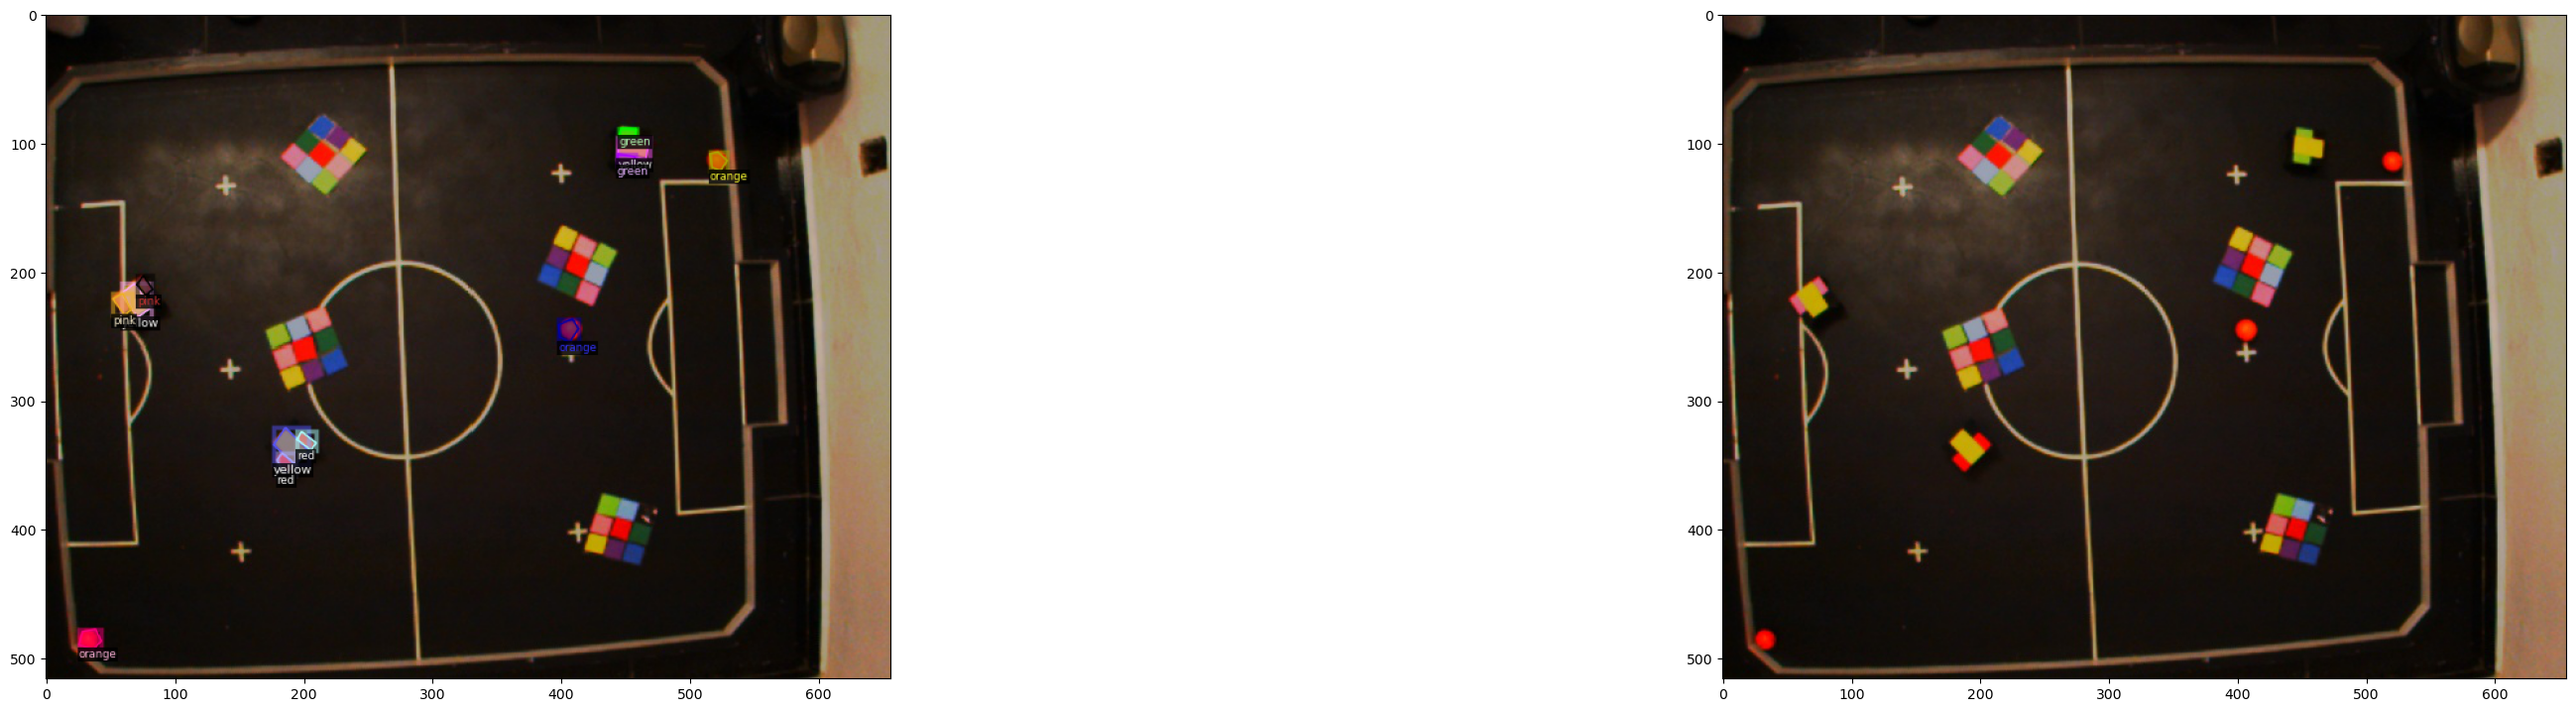

In [7]:
plt.figure(figsize=(40,40))
dataset_dicts = get_data(train_dir)
train_metadata = MetadataCatalog.get("train")
test_metadata = MetadataCatalog.get("test")
for row, d in enumerate(random.sample(dataset_dicts, 1)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.subplot(4, 2, 2*row+1)
    plt.imshow(out.get_image()[..., ::-1][..., ::-1])
    plt.subplot(4, 2, 2*row+2)
    plt.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))

# Set Configs

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("test", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes) 


# Augmentate Data

In [9]:
def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
                    #T.RandomContrast(0.8, 1.3),
                    #T.RandomSaturation(0.8, 1.3),
                    T.RandomRotation(angle=[90, 90]),
                          T.RandomBrightness(0.1, 2),
                            T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Train Model

In [10]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)


In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[12/13 15:25:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

In [12]:
trainer.train()

[12/13 15:25:12 d2.engine.train_loop]: Starting training from iteration 0


/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/13 15:25:23 d2.utils.events]:  eta: 0:02:21  iter: 19  total_loss: 3.369  loss_cls: 1.725  loss_box_reg: 0.3802  loss_mask: 0.6883  loss_rpn_cls: 0.2909  loss_rpn_loc: 0.3185  time: 0.5060  data_time: 0.0098  lr: 0.00016068  max_mem: 3272M
[12/13 15:25:31 d2.engine.hooks]: Overall training speed: 33 iterations in 0:00:17 (0.5173 s / it)
[12/13 15:25:31 d2.engine.hooks]: Total training time: 0:00:17 (0:00:00 on hooks)
[12/13 15:25:31 d2.utils.events]:  eta: 0:02:14  iter: 35  total_loss: 2.368  loss_cls: 0.7959  loss_box_reg: 0.5926  loss_mask: 0.6643  loss_rpn_cls: 0.07597  loss_rpn_loc: 0.2305  time: 0.5133  data_time: 0.0040  lr: 0.00028555  max_mem: 3272M


KeyboardInterrupt: 

# Visualize Augmentation

In [13]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

[12/13 15:25:34 d2.data.build]: Removed 0 images with no usable annotations. 48 images left.
[12/13 15:25:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/13 15:25:34 d2.data.build]: Using training sampler TrainingSampler
[12/13 15:25:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/13 15:25:34 d2.data.common]: Serializing 48 elements to byte tensors and concatenating them all ...
[12/13 15:25:34 d2.data.common]: Serialized dataset takes 0.12 MiB


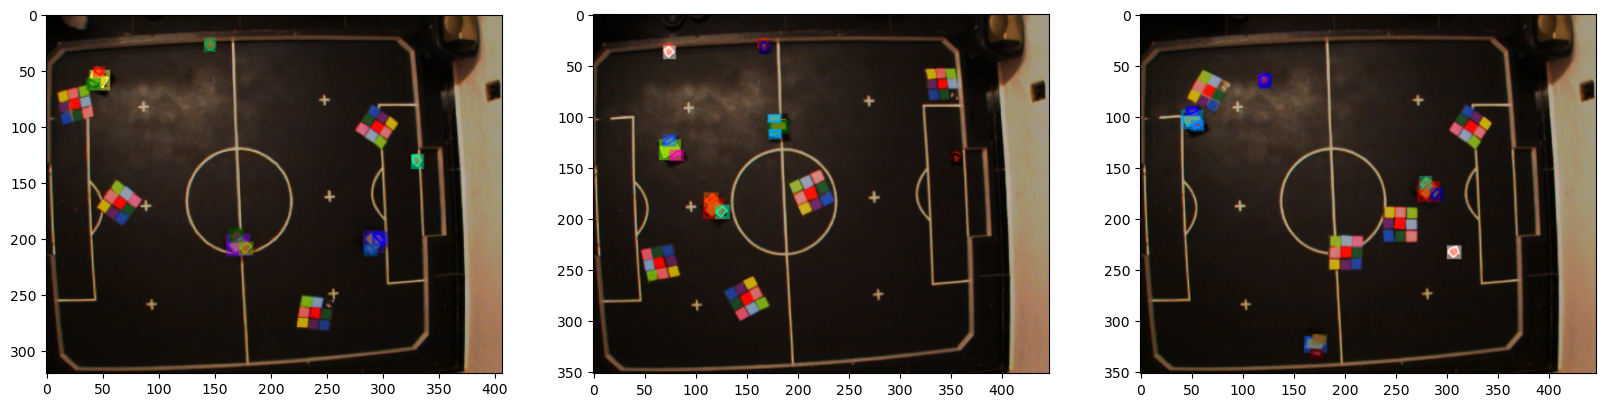

In [16]:
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:int(rows*cols)]):
    plt.subplot(rows, cols, i+1)
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()

    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

# Test Model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

In [ ]:
for index, filename in enumerate([file for file in os.listdir(test_dir) if not (file.endswith('.json') or file.startswith('output'))]):
    im = cv2.imread(test_dir +"/"+ filename)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata) 
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(test_dir + "/output_" + filename, out.get_image()[..., ::-1])

In [ ]:
for index, filename in enumerate(os.listdir(val_dir)):
    if filename.endswith('.json') or filename.startswith('output'):
        continue
    im = cv2.imread(val_dir + "/" + filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(val_dir + "/output_" + filename, out.get_image()[..., ::-1])

# Evaluate Model

In [ ]:
evaluator = COCOEvaluator("test", cfg, False, "./output/")
val_loader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)